Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

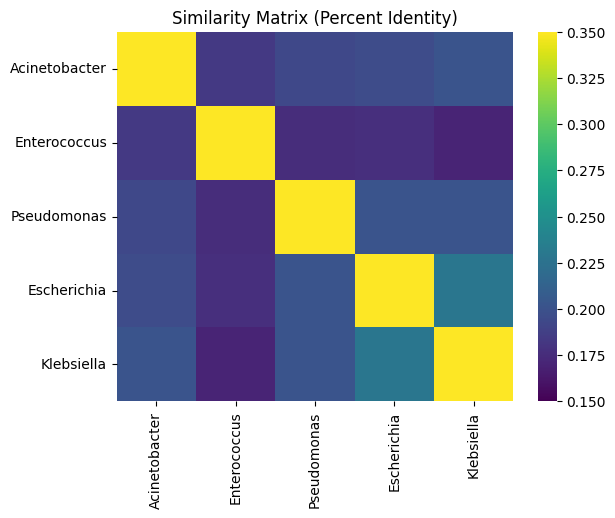

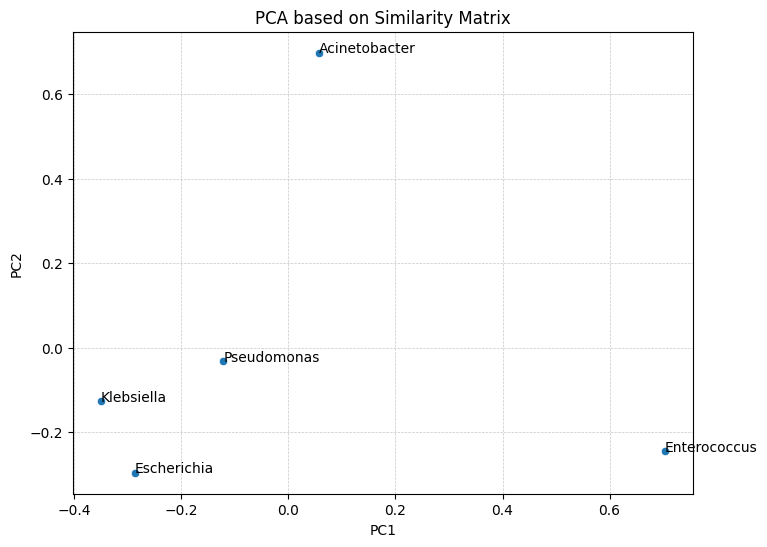

Distance Matrix:
 Acinetobacter   0.000000
Enterococcus    0.634368    0.000000
Pseudomonas 0.613172    0.649508    0.000000
Escherichia 0.608630    0.645723    0.596518    0.000000
Klebsiella  0.596518    0.660106    0.595761    0.542771    0.000000
    Acinetobacter   Enterococcus    Pseudomonas Escherichia Klebsiella


<Figure size 1000x600 with 0 Axes>

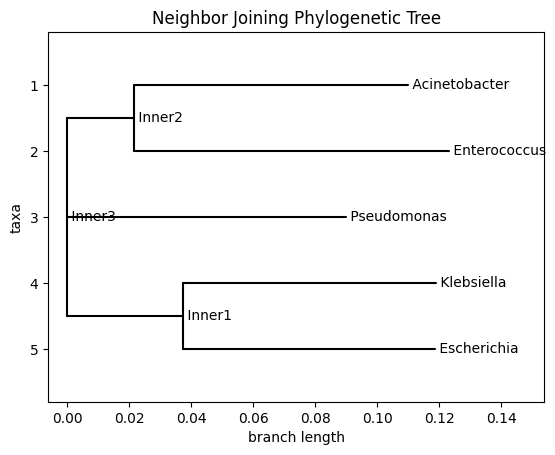

In [ ]:
!pip install biopython
!apt-get update
!apt-get install muscle -y
from Bio import SeqIO, AlignIO, Phylo
from Bio.Align.Applications import MuscleCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import os
os.listdir('/content/')
from collections import Counter


from Bio import Entrez
Entrez.email = "tanja.rotondari@uzh.ch"
df_sequences = pd.read_csv('/content/filtered_plasmid_sequences.csv')
print('Loaded plasmid sequences:', df_sequences.head())

fasta_file = 'plasmid_sequences.fasta'
with open(fasta_file, 'w') as f:
    for _, row in df_sequences.iterrows():
        f.write(f">{row['Bacteria']}_{row['ID']}\n{row['Sequence']}\n")
print(f'Sequences were saved to {fasta_file}.')

fasta_path = "plasmid_sequences.fasta"
records = list(SeqIO.parse(fasta_path, "fasta"))
for record in records:
    record.seq = record.seq[:1000]
short_fasta = "short_plasmide.fasta"
SeqIO.write(records, short_fasta, "fasta")


aligned_file = "aligned.aln"
muscle_exe = "/usr/bin/muscle"
muscle_cline = MuscleCommandline(muscle_exe, input=short_fasta, out=aligned_file)
stdout, stderr = muscle_cline()
alignment = AlignIO.read(aligned_file, "fasta")
print(alignment)


calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)
df_dist = pd.DataFrame(dm.matrix, index=dm.names, columns=dm.names)
similarity_matrix = 1 - df_dist
similarity_matrix = similarity_matrix.fillna(0)
similarity_matrix = (similarity_matrix + similarity_matrix.T) / 2
def kmer_similarity(seq1, seq2, k=3):
    kmers1 = Counter([str(seq1[i:i+k]) for i in range(len(seq1)-k+1)])
    kmers2 = Counter([str(seq2[i:i+k]) for i in range(len(seq2)-k+1)])
    shared = sum((kmers1 & kmers2).values())
    total = sum((kmers1 | kmers2).values())
    return shared / total
sns.heatmap(similarity_matrix, cmap="viridis", vmin=0.15, vmax=0.35)
plt.title("Similarity Matrix (Percent Identity)")
plt.show()


pca = PCA(n_components=2)
coords = pca.fit_transform(similarity_matrix)
df_pca = pd.DataFrame(coords, columns=["PC1", "PC2"], index=similarity_matrix.index)
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=df_pca)
for name, row in df_pca.iterrows():
    plt.text(row["PC1"], row["PC2"], name)
plt.title("PCA based on Similarity Matrix")
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.show()


alignment = AlignIO.read(aligned_file, "fasta")
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)
print('Distance Matrix:\n', dm)
constructor = DistanceTreeConstructor()
tree = constructor.nj(dm)
for clade in tree.find_clades():
    if clade.is_terminal():
        clade.branch_length *= 0.3
    else:
        clade.branch_length *= 1.5
plt.figure(figsize=(10, 6))
Phylo.draw(tree, do_show=False)
plt.title("Neighbor Joining Phylogenetic Tree")
plt.show()

first try to add ML with molecular clock for a real phylogeny

In [ ]:
# dieser Code runs out of Runtime
!pip install ete3 --upgrade --force-reinstall
!pip install pyqt5
import sys
print(sys.executable)
import sys
print(sys.executable)
import os
os.environ['QT_API'] = 'pyqt5'
from ete3 import Tree, TreeStyle
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# === STEP 1: Alignment einlesen ===
alignment = AlignIO.read("aligned.aln", "fasta")

# === STEP 2: Distance Matrix berechnen ===
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

# === STEP 3: Neighbor-Joining Baum erzeugen ===
constructor = DistanceTreeConstructor()
tree_biopy = constructor.nj(dm)

# === STEP 4: Biopython-Baum als Newick speichern ===
Phylo.write(tree_biopy, "tree_temp.nwk", "newick")

# === STEP 5: Newick-Baum mit ETE3 laden ===
tree = Tree("tree_temp.nwk", format=1)

# === STEP 6: Molekulare Uhr anwenden ===
tree.convert_to_ultrametric()

# === STEP 7: SVG-Export ===
ts = TreeStyle()
ts.show_leaf_name = True
tree.render("molecular_clock_tree.svg", tree_style=ts)

print("Molecular clock tree saved as 'molecular_clock_tree.svg'")

In [ ]:
# dieser Code runs out of Runtime, too
!apt-get update
!apt-get upgrade -y  # Optional, but recommended to upgrade all packages
!apt-get install --reinstall qtbase5-dev libqt5webkit5-dev  # Install necessary Qt dependencies
!apt install qt5-default
!apt-get install qtchooser
!yum install qt5-qtbase-devel
import os
os.environ['QT_QPA_PLATFORM_PLUGIN_PATH'] = '/usr/lib/x86_64-linux-gnu/qt5/plugins/platforms/'
from ete3 import Tree, TreeStyle
from Bio import AlignIO, Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

# === STEP 1: Alignment einlesen ===
alignment = AlignIO.read("aligned.aln", "fasta")

# === STEP 2: Distance Matrix berechnen ===
calculator = DistanceCalculator("identity")
dm = calculator.get_distance(alignment)

# === STEP 3: Neighbor-Joining Baum erzeugen ===
constructor = DistanceTreeConstructor()
tree_biopy = constructor.nj(dm)

# === STEP 4: Biopython-Baum als Newick speichern ===
Phylo.write(tree_biopy, "tree_temp.nwk", "newick")

# === STEP 5: Newick-Baum mit ETE3 laden ===
tree = Tree("tree_temp.nwk", format=1)

# === STEP 6: Molekulare Uhr anwenden ===
tree.convert_to_ultrametric()

from PIL import Image

# === STEP 7: SVG-Export ===
ts = TreeStyle()
ts.show_leaf_name = True

# Save tree to SVG file
tree.render("molecular_clock_tree.svg", tree_style=ts)

Image.open("molecular_clock_tree.svg").show()
Phylo.write(tree, "molecular_clock_tree.nwk", "newick")
print("Molecular clock tree saved as 'molecular_clock_tree.nwk'")
# print("Molekularuhr-Baum gespeichert als 'molecular_clock_tree.svg'")

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading